# Verbatim Coding Analysis: From Customer Voice to Actionable Strategy

## Project Overview

In the competitive world of women's e-commerce, customer feedback is a goldmine. However, with thousands of reviews pouring in, manually sifting through this unstructured text to find actionable insights is a near-impossible task. How can a business quickly identify if a new dress line has a sizing issue, or if a drop in ratings is due to fabric quality or slow shipping?

This notebook tackles this challenge head-on by building an automated **Verbatim Coding System**. It acts as an AI-powered analyst that reads, understands, and categorizes every single review, transforming a sea of raw feedback into a clear, prioritized roadmap for business improvement. We will move beyond simple star ratings to answer the crucial question: ***"Why?"***

The system's intelligence is built on a sophisticated, multi-layered approach:

### Key Capabilities:
- **Hybrid AI Approach**: Combines the precision of keyword-based rules with the discovery power of unsupervised machine learning (clustering) to ensure both accuracy and the ability to find new, emerging themes.
- **Sentiment-Driven Insights**: Goes beyond *what* customers say to understand *how they feel*, adding crucial emotional context (positive, negative, neutral) to each identified topic.
- **Actionable Priority Matrix**: Moves beyond simple charts to generate a business-focused matrix that weighs the **frequency** of a problem against its **impact** on customer ratings, telling you exactly what to fix first for maximum ROI.
- **Reliable & Production-Ready**: Implements a quality assurance layer with confidence scoring and exports trained models, making the entire system deployable for ongoing, real-time feedback analysis.

![Ecommerce Pic](https://unctad.org/sites/default/files/inline-images/2019-10-23_eTrade4Women_400x267.jpg)

### Dataset:
This analysis is performed on the **Women's E-commerce Clothing Reviews** dataset from [Kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews), containing over 23,000 real-world customer reviews.

## 🛠️ 1. Environment Setup and Data Loading
Before diving into analysis, we need to establish our technical foundation. This includes importing all necessary libraries for NLP, machine learning, visualization, and data manipulation. We'll also set up a proper directory structure for organizing our outputs and ensure all required NLTK resources are downloaded.

In [10]:
# Core librraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP and ML libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Utility libraries
import re
import json
import pickle
from collections import Counter, defaultdict
from datetime import datetime
import os

# Visualization libraries
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Environment setup complete!")

🚀 Environment setup complete!


### Directory Structure Setup
Organizing our outputs from the beginning ensures reproducibility and makes it easier to share results with stakeholders. We'll create separate folders for visualizations, reports, models, and processed data.

In [13]:
# Create directory structure for outputs
directories = [
    'outputs',
    'outputs/visualizations', 
    'outputs/reports',
    'outputs/models',
    'outputs/data'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)

print("📁 Directory structure created!")

📁 Directory structure created!


In [16]:
# Load Data
df = pd.read_csv("../data/Womens Clothing E-Commerce Reviews.csv" , index_col=0)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [18]:
# Display basic info
print(f"\n📋 Dataset Overview:")
print(f"   • Age range: {df['Age'].min()} - {df['Age'].max()}")
print(f"   • Rating range: {df['Rating'].min()} - {df['Rating'].max()}")
print(f"   • Total clothing items: {df['Clothing ID'].nunique():,}")
print(f"   • Product categories: {df['Department Name'].nunique()}")

# Display column information
print(f"\n📊 Column Information:")
for col in df.columns:
    dtype = df[col].dtype
    non_null = df[col].count()
    null_pct = (len(df) - non_null) / len(df) * 100
    print(f"   • {col}: {dtype} ({non_null:,} non-null, {null_pct:.1f}% missing)")


📋 Dataset Overview:
   • Age range: 18 - 99
   • Rating range: 1 - 5
   • Total clothing items: 1,206
   • Product categories: 6

📊 Column Information:
   • Clothing ID: int64 (23,486 non-null, 0.0% missing)
   • Age: int64 (23,486 non-null, 0.0% missing)
   • Title: object (19,676 non-null, 16.2% missing)
   • Review Text: object (22,641 non-null, 3.6% missing)
   • Rating: int64 (23,486 non-null, 0.0% missing)
   • Recommended IND: int64 (23,486 non-null, 0.0% missing)
   • Positive Feedback Count: int64 (23,486 non-null, 0.0% missing)
   • Division Name: object (23,472 non-null, 0.1% missing)
   • Department Name: object (23,472 non-null, 0.1% missing)
   • Class Name: object (23,472 non-null, 0.1% missing)


## 🔍 2. Exploratory Data Analysis (EDA)
Before building our verbatim coding system, we need to understand the data patterns, distributions, and relationships. This EDA will inform our coding categories and help identify potential issues or opportunities. We'll examine rating distributions, customer demographics, review characteristics, and departmental differences.

In [19]:
# Dataset structure analysis
print("🔍 DATASET STRUCTURE ANALYSIS")
print("=" * 50)

# Basic statistics
print("📊 Basic Statistics:")
print(f"Total Reviews: {len(df):,}")
print(f"Missing Values per Column:")
for col in df.columns:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df)) * 100
    print(f"   {col}: {missing_count:,} ({missing_pct:.1f}%)")

print(f"\n📈 Rating Distribution:")
rating_dist = df['Rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    print(f"   {rating} stars: {count:,} reviews ({count/len(df)*100:.1f}%)")

print(f"\n👗 Department Distribution:")
dept_dist = df['Department Name'].value_counts()
for dept, count in dept_dist.head().items():
    print(f"   {dept}: {count:,} reviews ({count/len(df)*100:.1f}%)")

# Additional insights
print(f"\n💡 Key Insights:")
print(f"   • Average rating: {df['Rating'].mean():.2f}")
print(f"   • Recommendation rate: {df['Recommended IND'].mean()*100:.1f}%")
print(f"   • Reviews with text: {df['Review Text'].notna().sum():,} ({df['Review Text'].notna().mean()*100:.1f}%)")
print(f"   • Reviews with titles: {df['Title'].notna().sum():,} ({df['Title'].notna().mean()*100:.1f}%)")

🔍 DATASET STRUCTURE ANALYSIS
📊 Basic Statistics:
Total Reviews: 23,486
Missing Values per Column:
   Clothing ID: 0 (0.0%)
   Age: 0 (0.0%)
   Title: 3,810 (16.2%)
   Review Text: 845 (3.6%)
   Rating: 0 (0.0%)
   Recommended IND: 0 (0.0%)
   Positive Feedback Count: 0 (0.0%)
   Division Name: 14 (0.1%)
   Department Name: 14 (0.1%)
   Class Name: 14 (0.1%)

📈 Rating Distribution:
   1 stars: 842 reviews (3.6%)
   2 stars: 1,565 reviews (6.7%)
   3 stars: 2,871 reviews (12.2%)
   4 stars: 5,077 reviews (21.6%)
   5 stars: 13,131 reviews (55.9%)

👗 Department Distribution:
   Tops: 10,468 reviews (44.6%)
   Dresses: 6,319 reviews (26.9%)
   Bottoms: 3,799 reviews (16.2%)
   Intimate: 1,735 reviews (7.4%)
   Jackets: 1,032 reviews (4.4%)

💡 Key Insights:
   • Average rating: 4.20
   • Recommendation rate: 82.2%
   • Reviews with text: 22,641 (96.4%)
   • Reviews with titles: 19,676 (83.8%)


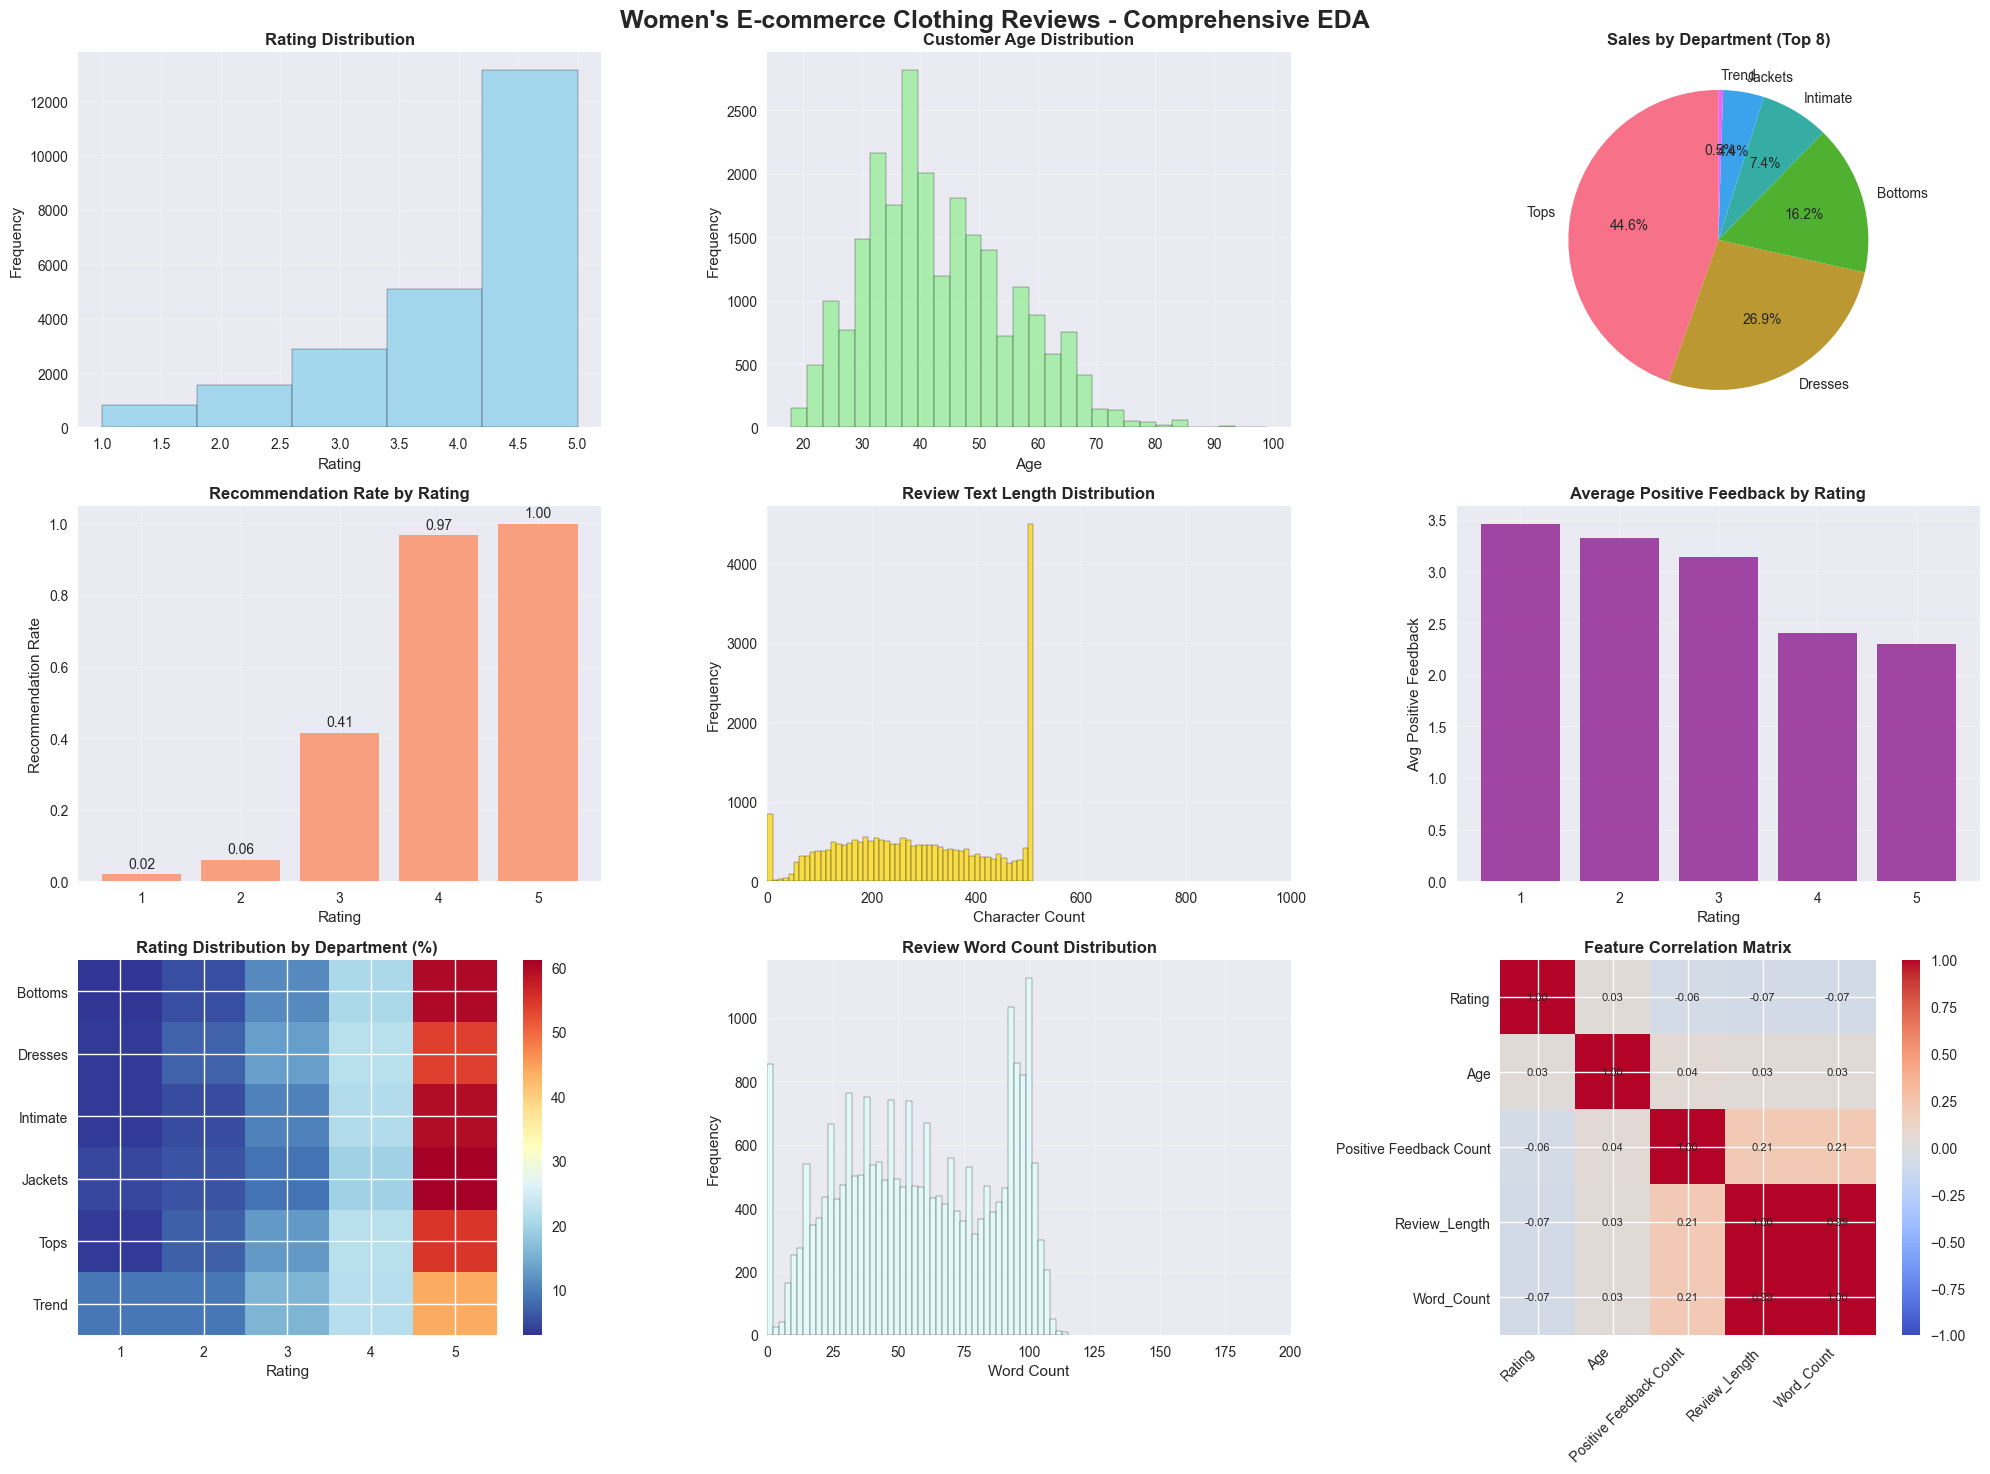

✅ Comprehensive EDA visualizations created!


In [21]:
# Visual EDA
# Create comprehensive EDA visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Women\'s E-commerce Clothing Reviews - Comprehensive EDA', 
             fontsize=18, fontweight='bold', y=0.98)

# 1. Rating Distribution
axes[0, 0].hist(df['Rating'], bins=5, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Rating Distribution', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Age Distribution
df_age_clean = df.dropna(subset=['Age'])
axes[0, 1].hist(df_age_clean['Age'], bins=30, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Customer Age Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Department Sales
dept_counts = df['Department Name'].value_counts().head(8)
axes[0, 2].pie(dept_counts.values, labels=dept_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 2].set_title('Sales by Department (Top 8)', fontweight='bold', fontsize=12)

# 4. Recommended vs Rating
recommend_rating = df.groupby('Rating')['Recommended IND'].mean()
bars = axes[1, 0].bar(recommend_rating.index, recommend_rating.values, color='coral', alpha=0.7)
axes[1, 0].set_title('Recommendation Rate by Rating', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Recommendation Rate')
axes[1, 0].grid(True, alpha=0.3)
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom')

# 5. Review Length Distribution
df['Review_Length'] = df['Review Text'].fillna('').str.len()
axes[1, 1].hist(df['Review_Length'], bins=50, color='gold', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Review Text Length Distribution', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Character Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(0, 1000)
axes[1, 1].grid(True, alpha=0.3)

# 6. Positive Feedback vs Rating
df_feedback = df.dropna(subset=['Positive Feedback Count'])
rating_feedback = df_feedback.groupby('Rating')['Positive Feedback Count'].mean()
bars = axes[1, 2].bar(rating_feedback.index, rating_feedback.values, color='purple', alpha=0.7)
axes[1, 2].set_title('Average Positive Feedback by Rating', fontweight='bold', fontsize=12)
axes[1, 2].set_xlabel('Rating')
axes[1, 2].set_ylabel('Avg Positive Feedback')
axes[1, 2].grid(True, alpha=0.3)

# 7. Rating by Department (Heatmap data prep)
dept_rating_crosstab = pd.crosstab(df['Department Name'], df['Rating'], normalize='index') * 100
dept_rating_matrix = dept_rating_crosstab.values
im = axes[2, 0].imshow(dept_rating_matrix, cmap='RdYlBu_r', aspect='auto')
axes[2, 0].set_title('Rating Distribution by Department (%)', fontweight='bold', fontsize=12)
axes[2, 0].set_xlabel('Rating')
axes[2, 0].set_xticks(range(len(dept_rating_crosstab.columns)))
axes[2, 0].set_xticklabels(dept_rating_crosstab.columns)
axes[2, 0].set_yticks(range(len(dept_rating_crosstab.index)))
axes[2, 0].set_yticklabels(dept_rating_crosstab.index, fontsize=10)
plt.colorbar(im, ax=axes[2, 0])

# 8. Word Count Distribution
df['Word_Count'] = df['Review Text'].fillna('').str.split().str.len()
axes[2, 1].hist(df['Word_Count'], bins=50, color='lightcyan', alpha=0.7, edgecolor='black')
axes[2, 1].set_title('Review Word Count Distribution', fontweight='bold', fontsize=12)
axes[2, 1].set_xlabel('Word Count')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].set_xlim(0, 200)
axes[2, 1].grid(True, alpha=0.3)

# 9. Correlation Heatmap (Numerical features only)
numerical_cols = ['Rating', 'Age', 'Positive Feedback Count', 'Review_Length', 'Word_Count']
corr_data = df[numerical_cols].corr()
im = axes[2, 2].imshow(corr_data.values, cmap='coolwarm', vmin=-1, vmax=1)
axes[2, 2].set_title('Feature Correlation Matrix', fontweight='bold', fontsize=12)
axes[2, 2].set_xticks(range(len(corr_data.columns)))
axes[2, 2].set_xticklabels(corr_data.columns, rotation=45, ha='right')
axes[2, 2].set_yticks(range(len(corr_data.index)))
axes[2, 2].set_yticklabels(corr_data.index)
plt.colorbar(im, ax=axes[2, 2])

# Add correlation values
for i in range(len(corr_data.index)):
    for j in range(len(corr_data.columns)):
        axes[2, 2].text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                       ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('outputs/visualizations/comprehensive_eda.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive EDA visualizations created!")